# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

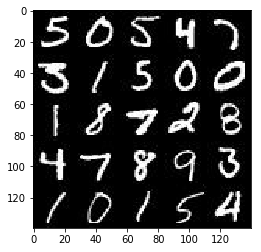

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

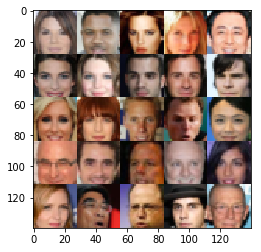

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    # TODO: Implement Function

    return real_inputs, z_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(input, alpha=0.2, name='leaky_relu'):
    return tf.maximum(input, input * alpha, name=name)

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        # images is 28x28xN
        
        # 14x14x64
        c1 = tf.layers.conv2d(images, filters=128, kernel_size=5, strides=2, padding='same')
        c1 = leaky_relu(c1, alpha, name='c1_relu')
        
        # 7x7x128
        c2 = tf.layers.conv2d(c1, filters=256, kernel_size=5, strides=2, padding='same')
        c2 = tf.layers.batch_normalization(c2, training=True)
        c2 = leaky_relu(c2, alpha)
        
        # 4x4x256
        c3 = tf.layers.conv2d(c2, filters=512, kernel_size=5, strides=2, padding='same')
        c3 = tf.layers.batch_normalization(c3, training=True)
        c3 = leaky_relu(c3, alpha)
        c3.set_shape((None, 4, 4, 512))

        c3 = tf.reshape(c3, (-1, 4*4*512))
        logits = tf.layers.dense(c3, 1)
        out = tf.nn.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, output_dim, training=True):
    alpha = 0.2
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not training):
        # First fully connected layer
        h1 = tf.layers.dense(z, 7*7*512)
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        h1 = tf.layers.batch_normalization(h1, training=training)
        h1 = leaky_relu(h1, alpha)
        
        # 14 x 14 x 256
        c1 = tf.layers.conv2d_transpose(h1, filters=256, kernel_size=5, strides=2, padding='same')
        c1 = tf.layers.batch_normalization(c1, training=training)
        c1 = leaky_relu(c1, alpha)
        
        # 28 x 28 x 128
        c2 = tf.layers.conv2d_transpose(c1, filters=128, kernel_size=5, strides=2, padding='same')
        c2 = tf.layers.batch_normalization(c2, training=training)
        c2 = leaky_relu(c2, alpha)

        # 28 x 28 x 64
        c3 = tf.layers.conv2d_transpose(c2, filters=64, kernel_size=5, strides=1, padding='same')
        c3 = tf.layers.batch_normalization(c3, training=training)
        c3 = leaky_relu(c3, alpha)

        # 28 x 28 x output_dim
        c4 = tf.layers.conv2d_transpose(c3, filters=output_dim, kernel_size=5, strides=1, padding='same')
        c4.set_shape((None, 28, 28, output_dim))
        logits = c4

        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, True)
    d_model_real, d_logits_real = discriminator(input_real, False)
    d_model_fake, d_logits_fake = discriminator(g_model, True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)), name='d_loss_real')
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)), name='d_loss_fake')
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)), name='g_loss')

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    print_every = 10
    show_every = 100
    show_size = 25
        
    _, w, h, c = data_shape
    input_real, input_z, lr = model_inputs(w, h, c, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, c)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    saver = tf.train.Saver()
    steps = 0
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # from [-0.5,0.5] to [-1,1]
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_size, input_z, c, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')

    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8884... Generator Loss: 1.4345
Epoch 1/2... Discriminator Loss: 1.5691... Generator Loss: 0.2998
Epoch 1/2... Discriminator Loss: 0.0384... Generator Loss: 3.9734
Epoch 1/2... Discriminator Loss: 4.4003... Generator Loss: 0.0143
Epoch 1/2... Discriminator Loss: 2.2538... Generator Loss: 6.8428
Epoch 1/2... Discriminator Loss: 2.8490... Generator Loss: 0.0879
Epoch 1/2... Discriminator Loss: 2.7235... Generator Loss: 0.1149
Epoch 1/2... Discriminator Loss: 2.3060... Generator Loss: 0.1674
Epoch 1/2... Discriminator Loss: 1.8356... Generator Loss: 0.3087
Epoch 1/2... Discriminator Loss: 1.8466... Generator Loss: 0.3263


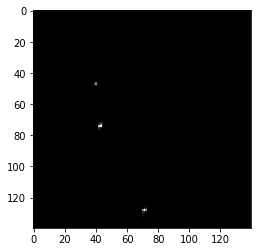

Epoch 1/2... Discriminator Loss: 1.7090... Generator Loss: 0.3938
Epoch 1/2... Discriminator Loss: 1.8074... Generator Loss: 0.2569
Epoch 1/2... Discriminator Loss: 1.1852... Generator Loss: 0.4995
Epoch 1/2... Discriminator Loss: 1.8281... Generator Loss: 2.4546
Epoch 1/2... Discriminator Loss: 1.4997... Generator Loss: 1.6146
Epoch 1/2... Discriminator Loss: 1.3055... Generator Loss: 1.1637
Epoch 1/2... Discriminator Loss: 1.3296... Generator Loss: 1.7995
Epoch 1/2... Discriminator Loss: 1.2475... Generator Loss: 1.2908
Epoch 1/2... Discriminator Loss: 0.5719... Generator Loss: 2.3535
Epoch 1/2... Discriminator Loss: 1.3019... Generator Loss: 1.2219


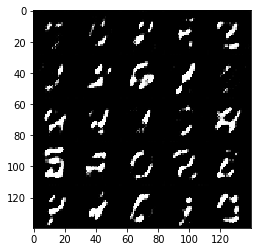

Epoch 1/2... Discriminator Loss: 1.2584... Generator Loss: 1.5832
Epoch 1/2... Discriminator Loss: 1.3368... Generator Loss: 2.0830
Epoch 1/2... Discriminator Loss: 1.2487... Generator Loss: 1.7463
Epoch 1/2... Discriminator Loss: 1.8296... Generator Loss: 2.7769
Epoch 1/2... Discriminator Loss: 1.6535... Generator Loss: 1.9982
Epoch 1/2... Discriminator Loss: 2.1303... Generator Loss: 1.5726
Epoch 1/2... Discriminator Loss: 1.5414... Generator Loss: 2.0908
Epoch 1/2... Discriminator Loss: 3.4783... Generator Loss: 4.8130
Epoch 1/2... Discriminator Loss: 1.4932... Generator Loss: 0.4132
Epoch 1/2... Discriminator Loss: 1.9901... Generator Loss: 0.2473


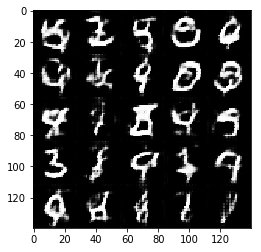

Epoch 1/2... Discriminator Loss: 1.4779... Generator Loss: 0.7437
Epoch 1/2... Discriminator Loss: 1.9751... Generator Loss: 2.6504
Epoch 1/2... Discriminator Loss: 0.9641... Generator Loss: 2.1195
Epoch 1/2... Discriminator Loss: 1.4391... Generator Loss: 2.2800
Epoch 1/2... Discriminator Loss: 1.1810... Generator Loss: 0.6795
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 0.9021
Epoch 1/2... Discriminator Loss: 2.1361... Generator Loss: 2.1114
Epoch 1/2... Discriminator Loss: 1.1317... Generator Loss: 1.0343
Epoch 1/2... Discriminator Loss: 0.9884... Generator Loss: 1.5462
Epoch 1/2... Discriminator Loss: 1.5066... Generator Loss: 1.6619


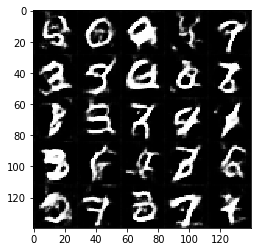

Epoch 1/2... Discriminator Loss: 1.1267... Generator Loss: 0.8947
Epoch 1/2... Discriminator Loss: 1.2492... Generator Loss: 0.9772
Epoch 1/2... Discriminator Loss: 1.2822... Generator Loss: 0.8637
Epoch 1/2... Discriminator Loss: 1.2904... Generator Loss: 1.4826
Epoch 1/2... Discriminator Loss: 1.3047... Generator Loss: 1.4690
Epoch 1/2... Discriminator Loss: 1.5863... Generator Loss: 1.8997
Epoch 2/2... Discriminator Loss: 1.2784... Generator Loss: 1.5429
Epoch 2/2... Discriminator Loss: 1.4522... Generator Loss: 1.7462
Epoch 2/2... Discriminator Loss: 1.2870... Generator Loss: 1.3177
Epoch 2/2... Discriminator Loss: 1.3630... Generator Loss: 1.1645


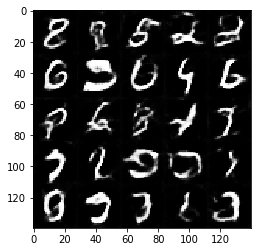

Epoch 2/2... Discriminator Loss: 1.2985... Generator Loss: 1.5541
Epoch 2/2... Discriminator Loss: 1.4568... Generator Loss: 0.8788
Epoch 2/2... Discriminator Loss: 1.4633... Generator Loss: 0.4269
Epoch 2/2... Discriminator Loss: 1.2973... Generator Loss: 0.6254
Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.5129
Epoch 2/2... Discriminator Loss: 1.3247... Generator Loss: 0.5303
Epoch 2/2... Discriminator Loss: 1.4258... Generator Loss: 0.5023
Epoch 2/2... Discriminator Loss: 1.5416... Generator Loss: 0.3586
Epoch 2/2... Discriminator Loss: 1.4264... Generator Loss: 0.4423
Epoch 2/2... Discriminator Loss: 1.1943... Generator Loss: 0.5937


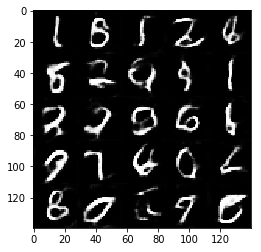

Epoch 2/2... Discriminator Loss: 1.1205... Generator Loss: 1.0161
Epoch 2/2... Discriminator Loss: 1.5480... Generator Loss: 0.3627
Epoch 2/2... Discriminator Loss: 1.2575... Generator Loss: 0.5303
Epoch 2/2... Discriminator Loss: 1.2862... Generator Loss: 1.2034
Epoch 2/2... Discriminator Loss: 1.1352... Generator Loss: 1.0425
Epoch 2/2... Discriminator Loss: 1.2822... Generator Loss: 0.9743
Epoch 2/2... Discriminator Loss: 1.2641... Generator Loss: 0.9004
Epoch 2/2... Discriminator Loss: 1.5528... Generator Loss: 1.7660
Epoch 2/2... Discriminator Loss: 1.2818... Generator Loss: 1.1102
Epoch 2/2... Discriminator Loss: 1.3425... Generator Loss: 1.1572


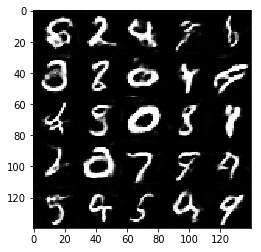

Epoch 2/2... Discriminator Loss: 1.2750... Generator Loss: 0.8118
Epoch 2/2... Discriminator Loss: 1.2757... Generator Loss: 0.8721
Epoch 2/2... Discriminator Loss: 1.3720... Generator Loss: 1.0418
Epoch 2/2... Discriminator Loss: 1.2456... Generator Loss: 0.8036
Epoch 2/2... Discriminator Loss: 1.5249... Generator Loss: 0.4216
Epoch 2/2... Discriminator Loss: 1.5130... Generator Loss: 0.3780
Epoch 2/2... Discriminator Loss: 1.3586... Generator Loss: 0.5902
Epoch 2/2... Discriminator Loss: 1.6661... Generator Loss: 2.0626
Epoch 2/2... Discriminator Loss: 1.2425... Generator Loss: 1.0683
Epoch 2/2... Discriminator Loss: 1.5858... Generator Loss: 0.3518


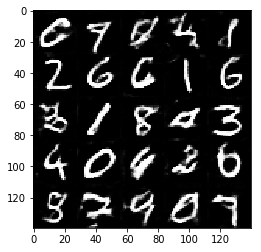

Epoch 2/2... Discriminator Loss: 1.3656... Generator Loss: 0.5159
Epoch 2/2... Discriminator Loss: 1.2012... Generator Loss: 0.5923
Epoch 2/2... Discriminator Loss: 1.4636... Generator Loss: 0.4727
Epoch 2/2... Discriminator Loss: 1.3050... Generator Loss: 0.5085
Epoch 2/2... Discriminator Loss: 1.3492... Generator Loss: 0.5213
Epoch 2/2... Discriminator Loss: 1.5211... Generator Loss: 0.3661
Epoch 2/2... Discriminator Loss: 1.3821... Generator Loss: 0.4658
Epoch 2/2... Discriminator Loss: 1.3724... Generator Loss: 0.5305
Epoch 2/2... Discriminator Loss: 1.4842... Generator Loss: 0.3895
Epoch 2/2... Discriminator Loss: 1.3755... Generator Loss: 1.0331


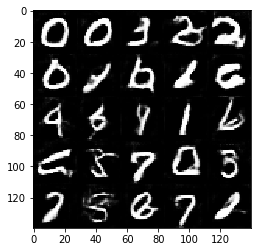

Epoch 2/2... Discriminator Loss: 1.2468... Generator Loss: 0.7419
Epoch 2/2... Discriminator Loss: 1.2410... Generator Loss: 0.8001
Epoch 2/2... Discriminator Loss: 1.3812... Generator Loss: 1.3954


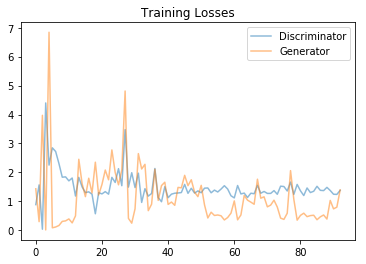

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 1.9515
Epoch 1/1... Discriminator Loss: 2.3336... Generator Loss: 1.5974
Epoch 1/1... Discriminator Loss: 2.6194... Generator Loss: 0.4652
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 1.3166
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 2.4729
Epoch 1/1... Discriminator Loss: 0.6729... Generator Loss: 1.5777
Epoch 1/1... Discriminator Loss: 1.7329... Generator Loss: 5.6663
Epoch 1/1... Discriminator Loss: 0.3744... Generator Loss: 3.3920
Epoch 1/1... Discriminator Loss: 0.2449... Generator Loss: 2.3930
Epoch 1/1... Discriminator Loss: 0.4374... Generator Loss: 1.6758


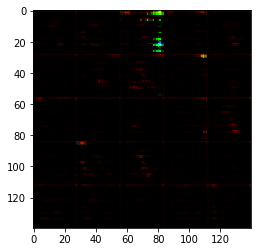

Epoch 1/1... Discriminator Loss: 0.6242... Generator Loss: 2.0009
Epoch 1/1... Discriminator Loss: 2.0248... Generator Loss: 0.3081
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 1.0409
Epoch 1/1... Discriminator Loss: 3.6205... Generator Loss: 12.6756
Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 0.0621... Generator Loss: 3.4701
Epoch 1/1... Discriminator Loss: 0.0326... Generator Loss: 8.2244
Epoch 1/1... Discriminator Loss: 0.0141... Generator Loss: 5.5770
Epoch 1/1... Discriminator Loss: 0.0242... Generator Loss: 4.4401
Epoch 1/1... Discriminator Loss: 0.0052... Generator Loss: 9.9695


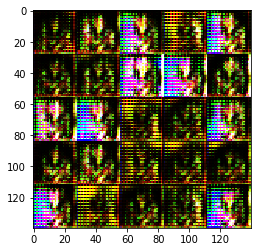

Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 10.5971
Epoch 1/1... Discriminator Loss: 1.6332... Generator Loss: 0.2825
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 1.7268
Epoch 1/1... Discriminator Loss: 2.5027... Generator Loss: 4.3788
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 2.9639... Generator Loss: 5.9566
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 1.9650
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 1.4310
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.6793... Generator Loss: 0.8546


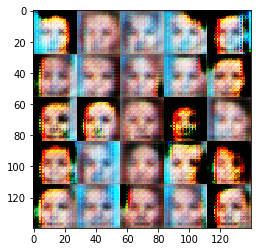

Epoch 1/1... Discriminator Loss: 1.6425... Generator Loss: 0.3476
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 1.8296
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 1.0546
Epoch 1/1... Discriminator Loss: 1.5653... Generator Loss: 0.5138
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 1.2866
Epoch 1/1... Discriminator Loss: 1.8303... Generator Loss: 0.2875
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 1.0998


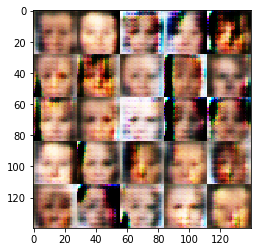

Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 2.4257
Epoch 1/1... Discriminator Loss: 3.0093... Generator Loss: 3.5354
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.4636
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 6.1896... Generator Loss: 5.2930
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 1.4144
Epoch 1/1... Discriminator Loss: 1.9377... Generator Loss: 2.4419
Epoch 1/1... Discriminator Loss: 1.6128... Generator Loss: 2.1764
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 0.8500


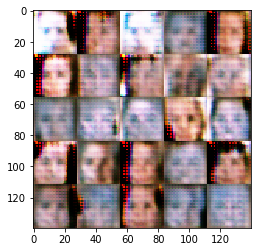

Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 1.0483
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 1.3148
Epoch 1/1... Discriminator Loss: 1.5592... Generator Loss: 0.5430
Epoch 1/1... Discriminator Loss: 1.7943... Generator Loss: 2.2055
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 1.3748
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 0.9148... Generator Loss: 0.9672


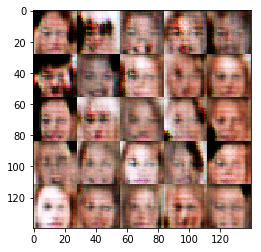

Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 1.4259
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 1.2184
Epoch 1/1... Discriminator Loss: 1.6115... Generator Loss: 2.4025
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.8857... Generator Loss: 0.3081
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 2.0304... Generator Loss: 0.1927
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.4303
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.5577


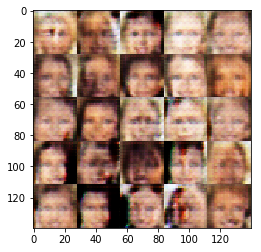

Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.5552
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.6471... Generator Loss: 1.8254
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 1.2635
Epoch 1/1... Discriminator Loss: 3.1944... Generator Loss: 0.0700
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.5412


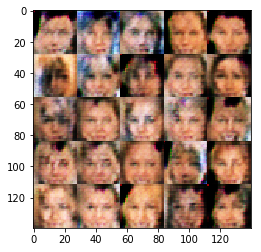

Epoch 1/1... Discriminator Loss: 1.9952... Generator Loss: 0.2664
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 1.0124
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.5769... Generator Loss: 0.5548
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 1.2737
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 1.7369... Generator Loss: 0.3211


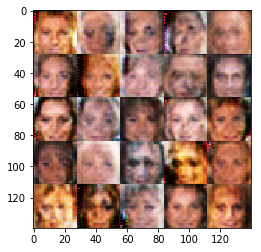

Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 1.2709
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 1.2457
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 1.2453
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.8743


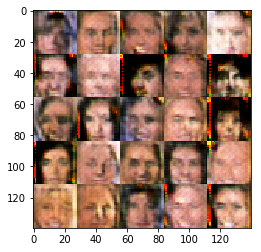

Epoch 1/1... Discriminator Loss: 1.6024... Generator Loss: 0.3900
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.5210
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 1.6634
Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 1.1471
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.6951... Generator Loss: 2.1050
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.5662


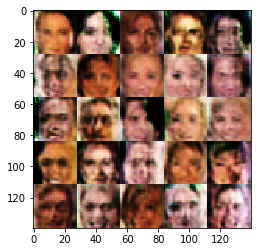

Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.4437
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.8490
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 1.3029
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 1.2706
Epoch 1/1... Discriminator Loss: 1.7846... Generator Loss: 0.4908
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 1.5727
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 1.0872
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.5483


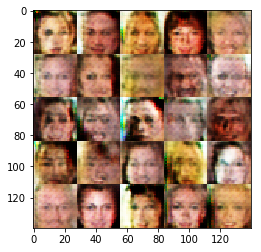

Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 1.0435
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.5635
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 1.3971
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.7894


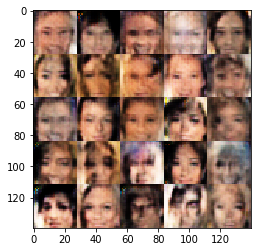

Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.8621... Generator Loss: 0.2650
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.6838


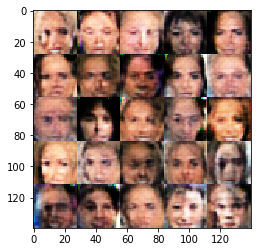

Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.5328
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 1.0878
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7497


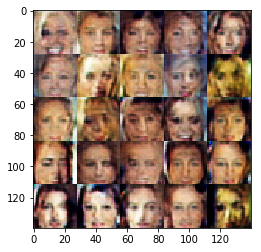

Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 1.2805
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 0.9985
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 1.4679
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.7023


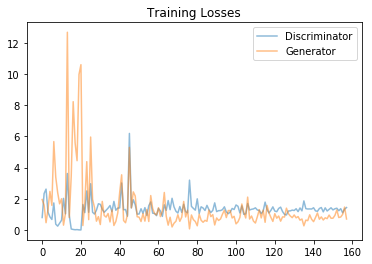

In [18]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.